# FOOTBALL (SOCCER) RANKING PREDICTION

This model is trained on 18,000+ football player data for ranking prediction using XGBoost. Also we hypertune our model and do a bit of basic feature selection techniques. Please keep in mind that this data is atleast a years old.



In [127]:

#importing libraries

import os
import pandas as pd
import numpy as np
from numpy import sort

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from collections import Counter
import scikitplot as skplt
from matplotlib.ticker import EngFormatter

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


#to make jupyter notebook display multiple outputs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



### Importing the Data

*data is being imported from the working directory*

In [69]:


data= pd.read_csv("Football Ranking.csv",index_col=0)

data.shape

(18207, 88)

> * Our data has 18207 rows and 88 columns

### Data Exploration,Wrangling and Visualisation

*using pandas and seaborn and matplotlib*

In [70]:

data.head(5)


,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [71]:
# just to make sure that we do not have any duplicate records in our data

data.duplicated().sum()

0

In [72]:

data.columns


Index(['ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiv

> * We do not need all the features in the data for our model so we only choose a few of them which is listed below

In [73]:

data= data[['Name','Age','Nationality','Overall','Value','Wage','Preferred Foot',
            'Crossing','Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 
            'Dribbling','Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 
            'Acceleration','SprintSpeed', 'Agility', 'Reactions', 'Balance', 
            'ShotPower','Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']]

data.shape


(18207, 41)

> * we have selected 41 columns form our original dataset for our regression model.
> * we kept a few features for visualisation purposes which we will remove later.

In [74]:

data.dtypes


Name                object
Age                  int64
Nationality         object
Overall              int64
Value               object
Wage                object
Preferred Foot      object
Crossing           float64
Finishing          float64
HeadingAccuracy    float64
ShortPassing       float64
Volleys            float64
Dribbling          float64
Curve              float64
FKAccuracy         float64
LongPassing        float64
BallControl        float64
Acceleration       float64
SprintSpeed        float64
Agility            float64
Reactions          float64
Balance            float64
ShotPower          float64
Jumping            float64
Stamina            float64
Strength           float64
LongShots          float64
Aggression         float64
Interceptions      float64
Positioning        float64
Vision             float64
Penalties          float64
Composure          float64
Marking            float64
StandingTackle     float64
SlidingTackle      float64
GKDiving           float64
G


> * We have a few object types in our data, some of them will be deleted later and the rest will be converted.
> * **Overall** is the dependent varibale in our data set.
> * Features **Name** and **Nationality** is not important for our analysis and hence can be deleted as said above.


In [75]:

data.head()


,Name,Age,Nationality,Overall,Value,Wage,Preferred Foot,Crossing,Finishing,HeadingAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,31,Argentina,94,€110.5M,€565K,Left,84.0,95.0,70.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,33,Portugal,94,€77M,€405K,Right,84.0,94.0,89.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Neymar Jr,26,Brazil,92,€118.5M,€290K,Right,79.0,87.0,62.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,De Gea,27,Spain,91,€72M,€260K,Right,17.0,13.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,K. De Bruyne,27,Belgium,91,€102M,€355K,Right,93.0,82.0,55.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


> * We can see that the features **Value** and **Wage** are string objects we need to convert them to int/float types.

In [76]:
# Converting Wage and Value columns

def wage_converter(value):
    value=value.replace('€',"")
    
    if 'M' in value:
        value= value.replace('M',"")
        value=float(value)*1000000
        
    elif 'K' in value:
        value= value.replace('K',"")
        value=float(value)*1000
        
    else:
        value=float(value)
        
    return value


data['Value']=data['Value'].apply(wage_converter)
data['Wage']=data['Wage'].apply(wage_converter)    

data.dtypes


Name                object
Age                  int64
Nationality         object
Overall              int64
Value              float64
Wage               float64
Preferred Foot      object
Crossing           float64
Finishing          float64
HeadingAccuracy    float64
ShortPassing       float64
Volleys            float64
Dribbling          float64
Curve              float64
FKAccuracy         float64
LongPassing        float64
BallControl        float64
Acceleration       float64
SprintSpeed        float64
Agility            float64
Reactions          float64
Balance            float64
ShotPower          float64
Jumping            float64
Stamina            float64
Strength           float64
LongShots          float64
Aggression         float64
Interceptions      float64
Positioning        float64
Vision             float64
Penalties          float64
Composure          float64
Marking            float64
StandingTackle     float64
SlidingTackle      float64
GKDiving           float64
G

> * As we can see the **Value** and **Wage** columns are now converted to float.


<AxesSubplot:xlabel='Name', ylabel='Wage'>

<AxesSubplot:xlabel='Name', ylabel='Value'>

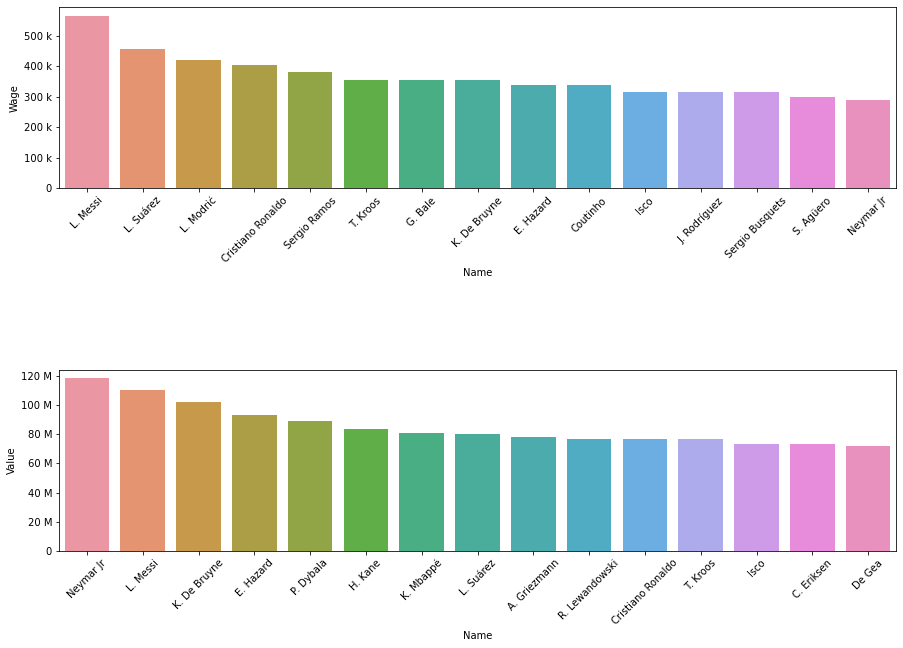

In [77]:
# Plotting 15 players who have the highest Wage and 15 most valueable players


fig,axes=plt.subplots(2,1,figsize=(15,10))
sns.barplot(x="Name",y="Wage",data=data.sort_values(by=['Wage'],ascending=False)[['Name','Wage']][:15],ax=axes[0])
sns.barplot(x="Name",y="Value",data=data.sort_values(by=['Value'],ascending=False)[['Name','Value']][:15],ax=axes[1])
fig.subplots_adjust(hspace=1)
axes[0].yaxis.set_major_formatter(EngFormatter())
axes[1].yaxis.set_major_formatter(EngFormatter())
for ax in fig.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        
        

0

             Number of Players
England                   1662
Germany                   1198
Spain                     1072
Argentina                  937
France                     914
Brazil                     827
Italy                      702
Colombia                   618
Japan                      478
Netherlands                453


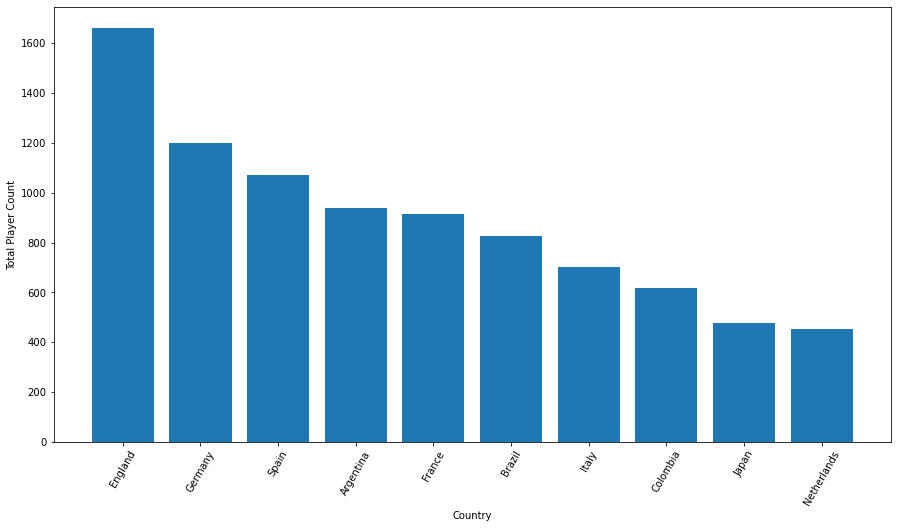

In [78]:
# Plotting the top 10 nations with most players

# We check if Nationality column has any null values in it.

data['Nationality'].isnull().sum()

def top_playcountry():
    nations= dict(data['Nationality'].value_counts()[:10])
    plt.figure(figsize=(15,8))
    plt.bar(nations.keys(),nations.values())
    plt.xticks(rotation=60)
    plt.xlabel('Country')
    plt.ylabel('Total Player Count')
    print(pd.DataFrame.from_dict(nations,orient='index',columns=['Number of Players']))
    
top_playcountry()    



> * We can see that the top number of countries with the most number of players are England, Germany, Spain, Argentina,France etc.

In [79]:
# oldest and youngest players in our data

print("The highest age in our dataset is",data['Age'].max())
data[data['Age']==data['Age'].max()]


print("The lowest age in our dataset is",data['Age'].min())
data[data['Age']==data['Age'].min()]


The highest age in our dataset is 45


,Name,Age,Nationality,Overall,Value,Wage,Preferred Foot,Crossing,Finishing,HeadingAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
4741,O. Pérez,45,Mexico,71,160000.0,8000.0,Right,19.0,14.0,24.0,...,23.0,62.0,23.0,12.0,11.0,70.0,64.0,65.0,73.0,74.0


The lowest age in our dataset is 16


,Name,Age,Nationality,Overall,Value,Wage,Preferred Foot,Crossing,Finishing,HeadingAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
11457,W. Geubbels,16,France,64,1000000.0,5000.0,Right,52.0,65.0,56.0,...,58.0,63.0,27.0,21.0,19.0,5.0,13.0,6.0,15.0,14.0
11732,A. Taoui,16,France,64,700000.0,3000.0,Left,63.0,69.0,65.0,...,65.0,52.0,17.0,19.0,20.0,8.0,6.0,6.0,8.0,11.0
12496,Pelayo Morilla,16,Spain,63,725000.0,1000.0,Left,63.0,61.0,52.0,...,58.0,55.0,22.0,21.0,26.0,11.0,11.0,6.0,15.0,7.0
12828,Guerrero,16,Spain,63,625000.0,1000.0,Left,50.0,51.0,57.0,...,53.0,55.0,56.0,64.0,58.0,6.0,5.0,10.0,6.0,14.0
13293,H. Massengo,16,France,62,450000.0,2000.0,Right,52.0,39.0,60.0,...,51.0,50.0,52.0,62.0,65.0,8.0,14.0,12.0,9.0,15.0
13567,Y. Verschaeren,16,Belgium,62,650000.0,1000.0,Right,48.0,54.0,39.0,...,49.0,50.0,35.0,38.0,35.0,15.0,6.0,12.0,10.0,7.0
15363,Y. Roemer,16,Netherlands,59,300000.0,1000.0,Right,38.0,66.0,50.0,...,71.0,48.0,22.0,15.0,20.0,9.0,9.0,11.0,10.0,9.0
15746,Y. Begraoui,16,France,59,350000.0,1000.0,Right,45.0,68.0,57.0,...,67.0,55.0,13.0,18.0,20.0,9.0,9.0,14.0,12.0,5.0
15793,J. Lahne,16,Sweden,59,300000.0,1000.0,Right,37.0,57.0,44.0,...,40.0,58.0,27.0,38.0,37.0,14.0,15.0,14.0,14.0,7.0
16081,J. Italiano,16,Australia,58,280000.0,1000.0,Right,43.0,50.0,36.0,...,40.0,57.0,36.0,38.0,43.0,7.0,7.0,9.0,10.0,5.0


> * The oldest player in our data set is of 45 years age.
> * The youngest players are of 16 years old and there are 42 of them in our data set.

In [80]:
# The highest and lowest ranking in our dataset

print("The highest ranking in our dataset is",data['Overall'].max())
data[data['Overall']==data['Overall'].max()]


print("The lowest ranking in our dataset is",data['Overall'].min())
data[data['Overall']==data['Overall'].min()]


The highest ranking in our dataset is 94


,Name,Age,Nationality,Overall,Value,Wage,Preferred Foot,Crossing,Finishing,HeadingAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,31,Argentina,94,110500000.0,565000.0,Left,84.0,95.0,70.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,33,Portugal,94,77000000.0,405000.0,Right,84.0,94.0,89.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0


The lowest ranking in our dataset is 46


,Name,Age,Nationality,Overall,Value,Wage,Preferred Foot,Crossing,Finishing,HeadingAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
18206,G. Nugent,16,England,46,60000.0,1000.0,Right,41.0,34.0,46.0,...,33.0,43.0,40.0,43.0,50.0,10.0,15.0,9.0,12.0,9.0


> * The highest ranking in our data is 94, Messi and Ronaldo are the highest ranked players.
> * The lowest ranking is 46

**We are converting our AGE variable into different age groups, Machine learning algorithms generally treat the larger numbers with more importance. To avoid this problem we are grouping age and later we one hot encode variables.**

In [81]:
# To convert age we use the cut function of pandas which sorts data into bins

data['Age']= pd.cut(x=data['Age'],bins=[10,20,30,40,50],labels=['10-20','20-30','30-40','40-50'])



20-30    12298
10-20     3327
30-40     2573
40-50        9
Name: Age, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='count'>

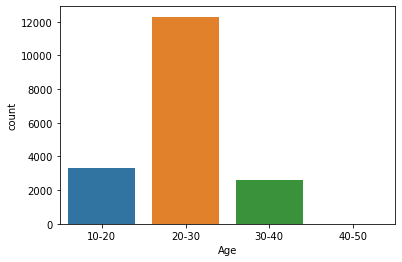

In [82]:
# Plotting the age groups

data['Age'].value_counts()
sns.countplot(data['Age'])


> * We can see that the **Age** is now grouped into bins and most of the players belong to the 20-30 group.

                Name  Overall
0           L. Messi       94
1  Cristiano Ronaldo       94
2          Neymar Jr       92
3             De Gea       91
4       K. De Bruyne       91
5          E. Hazard       91
6          L. Modrić       91
7          L. Suárez       91
8       Sergio Ramos       91
9           D. Godín       90


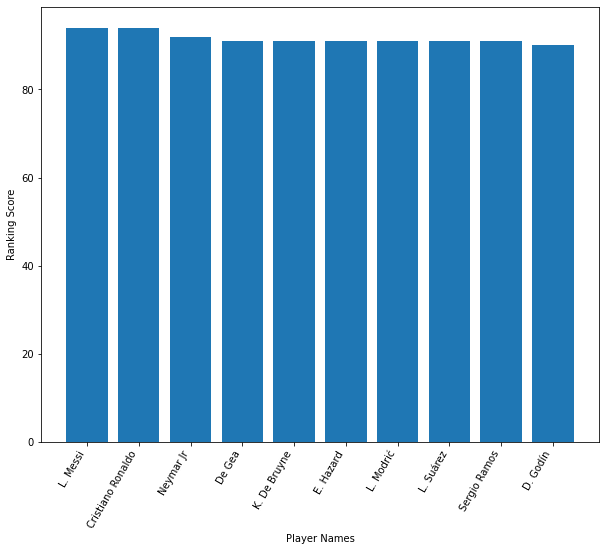

In [83]:
# Plotting top 10 players with the highest rankings

print(data[["Name","Overall"]].sort_values(by="Overall",ascending=False).reset_index(drop=True)[:10])
plt.figure(figsize=(10,8))
plt.bar(x="Name",height="Overall",data=data[["Name","Overall"]].sort_values(by="Overall",ascending=False)[:10])
plt.xlabel("Player Names")
plt.ylabel("Ranking Score")
plt.xticks(rotation=60,ha='right');


**We are dropping the Name and Nationality features from our data since it is not useful for a regression model**

In [84]:
data=data.drop(['Name','Nationality'],1)


**We are one hot encoding the Age groups and Preferred_foot variables using the get_dummies function which converts categorical variables into numeric**

In [85]:
# One hot enocdoing using the get_dummies function of pandas.


cols= ['Age','Preferred Foot']
data= pd.get_dummies(data,columns=cols)



> * Here we are not dropping the first level of each column since tree based alrogrithms are not affected by multicollinearity. However it is highly recommended to drop the first first level to deal with dummy variable trap for other regression models. Dummy variable traps happens when the encoded independent variables are multicollinear (the variables are highly correlated) thus leading to overfitting and poor prediction capability. 
> * One thing to keep in mind is that to avoid creating a bias, scaling(Normalize/Standardize) the data. However tree based algorithms does not require to scale the data and since we are using XGBoost which is a tree based model we are not scaling our data.

<AxesSubplot:>

We have a total of 48 rows with missing values


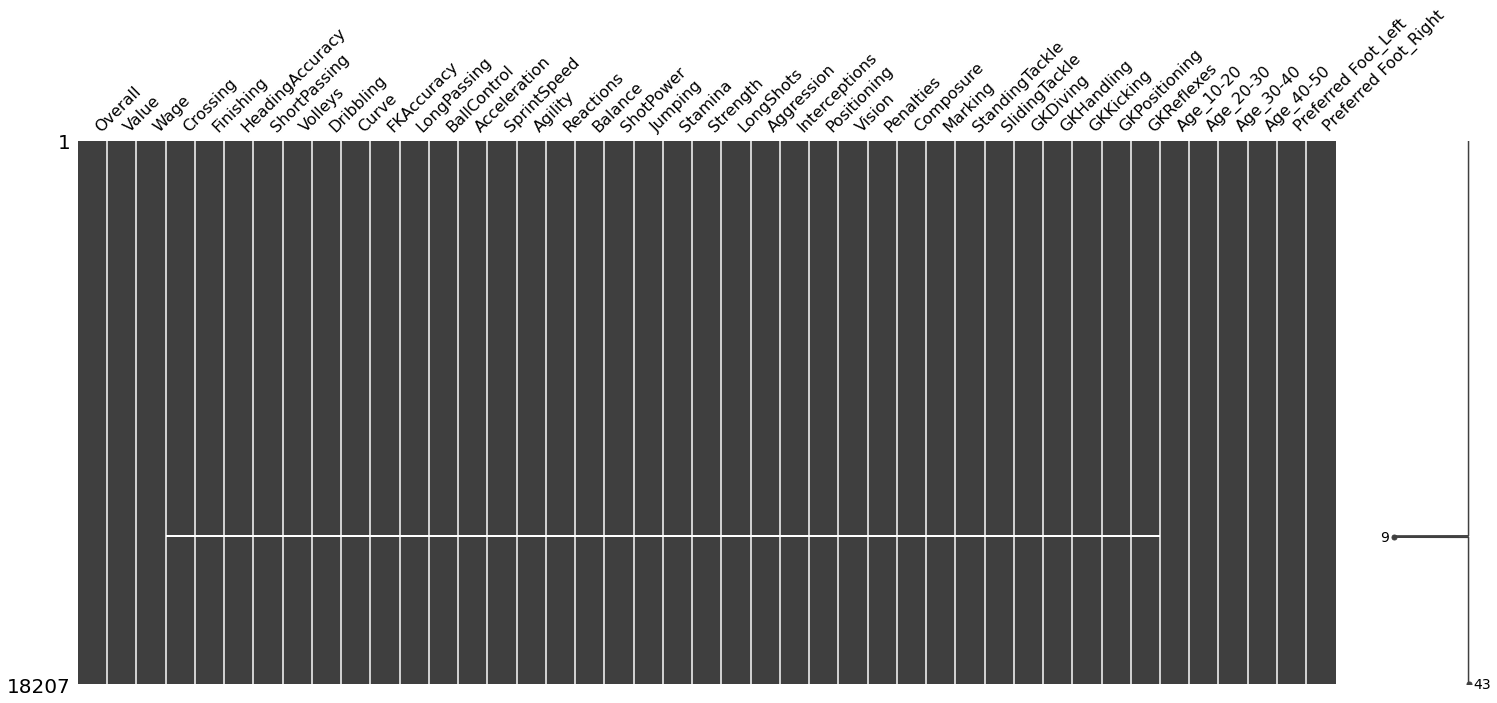

In [86]:
# We check if our data has any missing values in it 

msno.matrix(data)

print("We have a total of",data.shape[0]-data.dropna(axis=0).shape[0], "rows with missing values")


<AxesSubplot:>

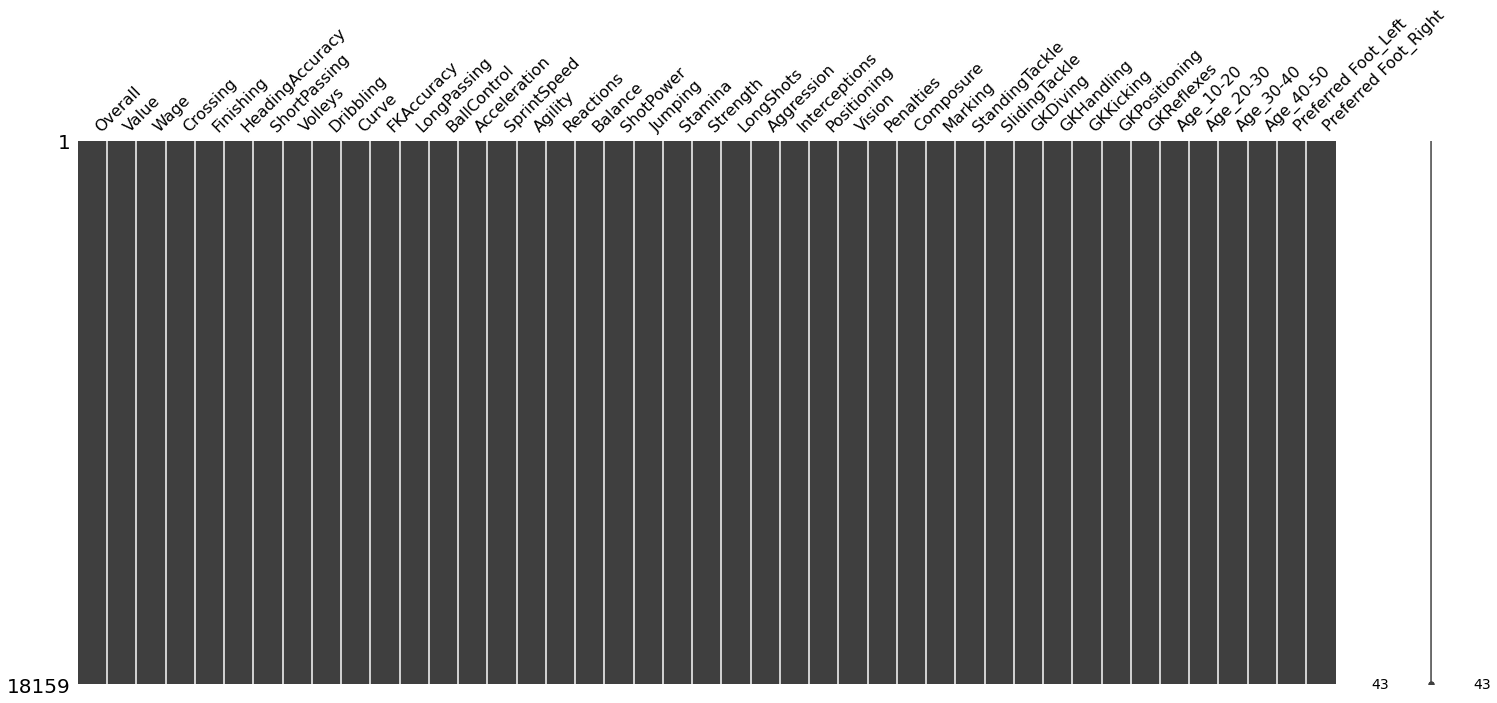

In [87]:
# We remove those rows with missing values

data.dropna(axis=0,inplace=True)

msno.matrix(data)



In [88]:
# I have kept the last row of our data to test our model

testing = data.tail(1)


In [89]:
# We select all the data except the last row and seperate dependent and independent variables

data=data[:-1]

X= data.drop(["Overall"],axis=1)
y= data["Overall"]


In [90]:
# We split our data into train and test sets into 70 and 30 percents using the train_test_split method of scikitlearn.

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

X_train.shape,X_test.shape


((12710, 42), (5448, 42))

> * We have 12710 records in our training and 5448 records in our test set.

## Creating the Model

For our football ranking prediction regression problem we use **XGBoost Regressor** Model using **mean squared error** and **r squared** as model performance evaluation metrics.

In [91]:
# We create the model, fits and predicts the data

# We use Mean_Squared_Error and R squared Score to evaluate our model.


xgb=  XGBRegressor()

xgb.fit(X_train,y_train)

pred= xgb.predict(X_test)

mean_sq_error= mean_squared_error(y_test,pred)
print("mean_squared_error",mean_sq_error)

print("R squared",r2_score(y_test,pred))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

mean_squared_error 0.7200241876412005
R squared 0.9849290627953501


> * Model has a mean_squared_error of 0.72 which is good and a very good r squared score of 0.98.

In [94]:
# We can now test our model on the last row of the data that we kept aside for testing

testing.drop(["Overall"],axis=1,inplace=True)

xgb.predict(testing)



array([49.319214], dtype=float32)

> * Our model predicts quite good on this unseen data. The acutall overall score for this testing is 46.

## Hyperparameter Tuning XGBoost

**Hyperparameters control the overall learning of a machine learning model. Hyperparameter tuning main objective is to find the optimal hyperparameter to minimize the loss function of the model to give better performance.**

In this XGBoost model we try to find the best hyperparameters using scikit-learns RandomizedSearchCV function. The reason we choose RandomSearchCV is that it is less computationally expensive and less time consuming when compared to another optimization technique GridSearchCV. RandomSearchCV chooses parameter(Hyperparameters) randomly to find the best solution for the model.

An important thing is that do not tune on the test data. XGBoost Algorithm has a lot of hyperparameter, most of them are not very important and does not have much effect on the model performance. Here I have chosen a few of them.
* Base_Score is basically the prior probability or the initial prediction for all instances, the default value is 0.5. Generally base_score values will not affect the model if there are large number of iterations.
* Gamma is used to prune the tree down and is done from the bottom once the tree is complete. If the gain is less than gamma it removes that node. It helps the model from overfitting. When gamma is high, model is more likely not to overfit.
* Learning_rate is the shrinkage size for the feature weights at each step or tree. If the learning rate is too high the model shrinks the feature weights and thus creates overfitting. The default value is 0.3.
* Max_depth is the maximum depth of the tree. The default value is 6. Higher the depth more complex the model will become and more are the chances of overfitting.
* N_estimators is the number of trees that you want your model to have.

Also I am using early stoppage for my randomsearchcv based on the metric Root mean squared error where i am testing it with the test data. So if the loss function is not decreasing for 15 rounds the random search for hyperparameter is stopped. 
We are crossvalidating the randomsearchcv and iterations is 50. Therefore there will be 250 fits on our data and scoring method is negative mean squared error.

In [95]:

base_score= [0.01,0.1,0.25,0.5,0.75,1]
gamma=[0.05,0.1,0.3,0.5,0.75,1,2,5,10]
learning_rate=[0.05,0.1,0.15,0.2,0.25,0.5,0.75]
max_depth=[1,3,4,5,7,8,9]
n_estimators=[50,75,100,500,1000,1500]

param_grid={
    'n_estimators':n_estimators,
    'base_score':base_score,
    'gamma':gamma,
    'learning_rate':learning_rate,
    'max_depth':max_depth}

fit_params= {"early_stopping_rounds":15, 
        "eval_metric" : "rmse", 
        "eval_set" : [[X_test, y_test]]}

random_searchcv= RandomizedSearchCV(estimator=xgb,
                                    param_distributions=param_grid,
                                    cv=5,n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1,verbose=5,return_train_score=True,
                                    random_state=42)

random_searchcv.fit(X_train,y_train,**fit_params)




Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.2min finished


[0]	validation_0-rmse:59.84421
Will train until validation_0-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:53.87777
[2]	validation_0-rmse:48.50763
[3]	validation_0-rmse:43.67371
[4]	validation_0-rmse:39.32207
[5]	validation_0-rmse:35.40534
[6]	validation_0-rmse:31.88485
[7]	validation_0-rmse:28.71208
[8]	validation_0-rmse:25.85519
[9]	validation_0-rmse:23.28739
[10]	validation_0-rmse:20.97558
[11]	validation_0-rmse:18.89513
[12]	validation_0-rmse:17.02358
[13]	validation_0-rmse:15.34263
[14]	validation_0-rmse:13.82719
[15]	validation_0-rmse:12.46362
[16]	validation_0-rmse:11.23589
[17]	validation_0-rmse:10.13300
[18]	validation_0-rmse:9.14009
[19]	validation_0-rmse:8.24742
[20]	validation_0-rmse:7.44457
[21]	validation_0-rmse:6.72390
[22]	validation_0-rmse:6.07543
[23]	validation_0-rmse:5.49324
[24]	validation_0-rmse:4.97126
[25]	validation_0-rmse:4.50340
[26]	validation_0-rmse:4.08457
[27]	validation_0-rmse:3.70929
[28]	validation_0-rmse:3.37418
[29]	validation_0-rmse:3.073

[257]	validation_0-rmse:0.79716
[258]	validation_0-rmse:0.79672
[259]	validation_0-rmse:0.79665
[260]	validation_0-rmse:0.79624
[261]	validation_0-rmse:0.79587
[262]	validation_0-rmse:0.79568
[263]	validation_0-rmse:0.79562
[264]	validation_0-rmse:0.79542
[265]	validation_0-rmse:0.79525
[266]	validation_0-rmse:0.79500
[267]	validation_0-rmse:0.79464
[268]	validation_0-rmse:0.79441
[269]	validation_0-rmse:0.79414
[270]	validation_0-rmse:0.79410
[271]	validation_0-rmse:0.79390
[272]	validation_0-rmse:0.79318
[273]	validation_0-rmse:0.79279
[274]	validation_0-rmse:0.79242
[275]	validation_0-rmse:0.79210
[276]	validation_0-rmse:0.79184
[277]	validation_0-rmse:0.79171
[278]	validation_0-rmse:0.79151
[279]	validation_0-rmse:0.79131
[280]	validation_0-rmse:0.79118
[281]	validation_0-rmse:0.79108
[282]	validation_0-rmse:0.79115
[283]	validation_0-rmse:0.79102
[284]	validation_0-rmse:0.79094
[285]	validation_0-rmse:0.79103
[286]	validation_0-rmse:0.79076
[287]	validation_0-rmse:0.79077
[288]	va

[514]	validation_0-rmse:0.76600
[515]	validation_0-rmse:0.76600
[516]	validation_0-rmse:0.76601
[517]	validation_0-rmse:0.76604
[518]	validation_0-rmse:0.76592
[519]	validation_0-rmse:0.76578
[520]	validation_0-rmse:0.76572
[521]	validation_0-rmse:0.76569
[522]	validation_0-rmse:0.76558
[523]	validation_0-rmse:0.76550
[524]	validation_0-rmse:0.76545
[525]	validation_0-rmse:0.76538
[526]	validation_0-rmse:0.76543
[527]	validation_0-rmse:0.76538
[528]	validation_0-rmse:0.76542
[529]	validation_0-rmse:0.76535
[530]	validation_0-rmse:0.76536
[531]	validation_0-rmse:0.76533
[532]	validation_0-rmse:0.76530
[533]	validation_0-rmse:0.76528
[534]	validation_0-rmse:0.76528
[535]	validation_0-rmse:0.76524
[536]	validation_0-rmse:0.76510
[537]	validation_0-rmse:0.76506
[538]	validation_0-rmse:0.76507
[539]	validation_0-rmse:0.76491
[540]	validation_0-rmse:0.76480
[541]	validation_0-rmse:0.76485
[542]	validation_0-rmse:0.76475
[543]	validation_0-rmse:0.76468
[544]	validation_0-rmse:0.76457
[545]	va

[771]	validation_0-rmse:0.75647
[772]	validation_0-rmse:0.75650
[773]	validation_0-rmse:0.75645
[774]	validation_0-rmse:0.75642
[775]	validation_0-rmse:0.75642
[776]	validation_0-rmse:0.75636
[777]	validation_0-rmse:0.75628
[778]	validation_0-rmse:0.75625
[779]	validation_0-rmse:0.75614
[780]	validation_0-rmse:0.75609
[781]	validation_0-rmse:0.75603
[782]	validation_0-rmse:0.75596
[783]	validation_0-rmse:0.75590
[784]	validation_0-rmse:0.75585
[785]	validation_0-rmse:0.75580
[786]	validation_0-rmse:0.75579
[787]	validation_0-rmse:0.75575
[788]	validation_0-rmse:0.75572
[789]	validation_0-rmse:0.75575
[790]	validation_0-rmse:0.75571
[791]	validation_0-rmse:0.75565
[792]	validation_0-rmse:0.75564
[793]	validation_0-rmse:0.75565
[794]	validation_0-rmse:0.75561
[795]	validation_0-rmse:0.75559
[796]	validation_0-rmse:0.75556
[797]	validation_0-rmse:0.75552
[798]	validation_0-rmse:0.75552
[799]	validation_0-rmse:0.75545
[800]	validation_0-rmse:0.75544
[801]	validation_0-rmse:0.75545
[802]	va

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_par...
                                          validate_parameters=1,
                                          verbosity=None),
                   n_it

> * We can see that our model did early stop at the 968th iteration as there were no further improvements in each tree after 953.

In [96]:
#finding the best estimator and examining the cross validation results

random_searchcv.best_estimator_

pd.DataFrame(random_searchcv.cv_results_)


XGBRegressor(base_score=0.1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_base_score,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.140604,0.541856,0.044282,0.004260,1000,1,0.5,2,0.25,"{'n_estimators': 1000, 'max_depth': 1, 'learni...",...,-1.278102,0.061085,34,-1.068308,-1.101286,-1.074901,-1.103496,-1.087859,-1.087170,0.013947
1,5.573100,0.148566,0.022340,0.001492,500,1,0.5,10,1,"{'n_estimators': 500, 'max_depth': 1, 'learnin...",...,-1.431678,0.069229,41,-1.262875,-1.287539,-1.264217,-1.279719,-1.287028,-1.276276,0.010764
2,2.953903,0.197263,0.014561,0.000798,100,5,0.75,0.3,0.01,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",...,-1.125992,0.031532,30,-0.359447,-0.360031,-0.380228,-0.353076,-0.335440,-0.357644,0.014373
3,3.739801,0.078681,0.019747,0.001163,100,4,0.15,0.05,0.25,"{'n_estimators': 100, 'max_depth': 4, 'learnin...",...,-0.824933,0.030979,17,-0.573775,-0.562370,-0.558663,-0.552960,-0.575397,-0.564633,0.008677
4,4.772641,0.087089,0.025531,0.003711,100,5,0.25,0.05,1,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",...,-0.759324,0.039254,12,-0.295218,-0.292546,-0.293049,-0.284279,-0.297552,-0.292529,0.004490
5,4.296313,0.159422,0.017553,0.001739,75,7,0.25,10,0.1,"{'n_estimators': 75, 'max_depth': 7, 'learning...",...,-0.865036,0.049176,24,-0.516506,-0.524268,-0.505603,-0.516260,-0.516716,-0.515871,0.005953
6,4.332218,0.026201,0.023338,0.000798,50,9,0.25,0.75,0.75,"{'n_estimators': 50, 'max_depth': 9, 'learning...",...,-0.840334,0.027832,19,-0.103321,-0.109122,-0.107668,-0.108943,-0.109850,-0.107781,0.002338
7,14.586805,0.849358,0.064628,0.003116,1000,7,0.15,0.3,0.75,"{'n_estimators': 1000, 'max_depth': 7, 'learni...",...,-0.680388,0.030086,7,-0.075312,-0.060618,-0.061465,-0.060988,-0.064805,-0.064638,0.005541
8,19.751997,2.744834,0.091556,0.012269,1000,5,0.2,0.1,0.25,"{'n_estimators': 1000, 'max_depth': 5, 'learni...",...,-0.649385,0.008576,5,-0.075693,-0.062864,-0.101257,-0.050270,-0.083569,-0.074730,0.017446
9,2.189545,0.029252,0.014162,0.000399,75,3,0.15,0.5,0.25,"{'n_estimators': 75, 'max_depth': 3, 'learning...",...,-1.110640,0.043171,29,-0.923248,-0.908772,-0.913846,-0.923843,-0.917319,-0.917406,0.005706


> * If we look at the cross validation results we can see that the 50th iteration gave us the best result since it has the lowest test_score value for the loss function (neg_mean_squared_error). We can also compare the train scores at each iteration for the 5 cross validation.
> * We can see that hypertuning gave us the best score for each hyperparameters that we passed.
* Base_score = 0.1
* Gamma =0.1
* learning_rate = 0.1
* max_depth = 5
* n_estimators= 1500

In [97]:
# Creating a XGBoost model with the best hyperparameters

xgbtuned= XGBRegressor(base_score=0.1, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
                       importance_type='gain', interaction_constraints='',
                       learning_rate=0.1, max_delta_step=0, max_depth=5,
                       min_child_weight=1, missing=None, monotone_constraints='()',
                       n_estimators=1500, n_jobs=0, num_parallel_tree=1, random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                       tree_method='exact', validate_parameters=1, verbosity=None)

xgbtuned.fit(X_train,y_train)



XGBRegressor(base_score=0.1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=1500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
# Predicting the ranking using our newly created tuned XGBoost model

pred_tuned=xgbtuned.predict(X_test)

mean_squared_error(y_test,pred_tuned)


r2_score(y_test,pred_tuned)

# testing the accuracy with the one unseen data instance

xgbtuned.predict(testing)


0.5663591271387249

0.9881454498516911

array([48.781357], dtype=float32)

> * There is a small increase in the model performance, we got a slightly better mean_squared_error for the tuned Xgboost model.

> When it comes to machine learning models, most of the times hypertuning may not give better results or improve our model performance significantly. Most of the default hyperparameter in the model is sufficient enough to give good results. However it is true that a few tweaks can make your model better on unseen data and prevent overfitting, from a business point of view Hypertuning is very much time consuming and computationally expensive. Major chances are that most of the models are good enough for deployment without hypertuning, if its trained on the data with the right set of features.

> Quality of the features used in the model will influence the models learning pattern and will improve the overall performance of it. Feature engineering is an important step when building a model. The raw data needs to be transformed into machine readable form so that algorithms can work smoothly with better efficiency. Feature Engineering, Feature Extraction and Feature Selection are useful in gaining the quality of the features used for the machine learning model.

> We can check a few methods of Feature Selection on our dataset.

## Feature Selection

Feature selection is cruical to select appropriate features from a noisy data. It reduces the dimensionality of the data by removing redundant features. Feature selection reduces the computational cost, training time and can reduce overfitting. Feature selection methods can basically be classified into three: Filter Methods, Wrapper Methods and Embedded Methods.

In this i try to do feature selection based on pearson's coefficient correlation method, feature importance feature selection method and a wrapper method.

#### Correlation Filter Method

Correlation tell us how two variables are related to each other. The correlation values falls between 1 and -1, were higher the correlation values gets to 1 the more positive correlation exists (one variable increases/decreases with respect to the other) and the closer the values get to -1 the variables are highly negatively correlated (one variable decreases when the other variable increases and vice versa). The correlation close to zero or 0 shows there is not much linear relationship between the variables. Also usually anything above 0.8 and -0.8 is highly correlated and are not significant. Correlation between independent variables is known as multicollinearity as that is what we are going to deal here. There are other methods such as VIF(variation inflation factor) that can be used to find multicollinearity.

Also keep in mind that correlation necessarily does not imply casuation (eg: variable A causes variable B). And a high correlation between dependent and independent variable is considered significant as this explains the change in dependent variable.


{'Acceleration',
 'BallControl',
 'Dribbling',
 'FKAccuracy',
 'Finishing',
 'GKDiving',
 'GKHandling',
 'GKPositioning',
 'GKReflexes',
 'LongPassing',
 'LongShots',
 'Marking',
 'Positioning',
 'SlidingTackle',
 'StandingTackle',
 'Volleys',
 'Wage'}

<Figure size 1440x1440 with 0 Axes>

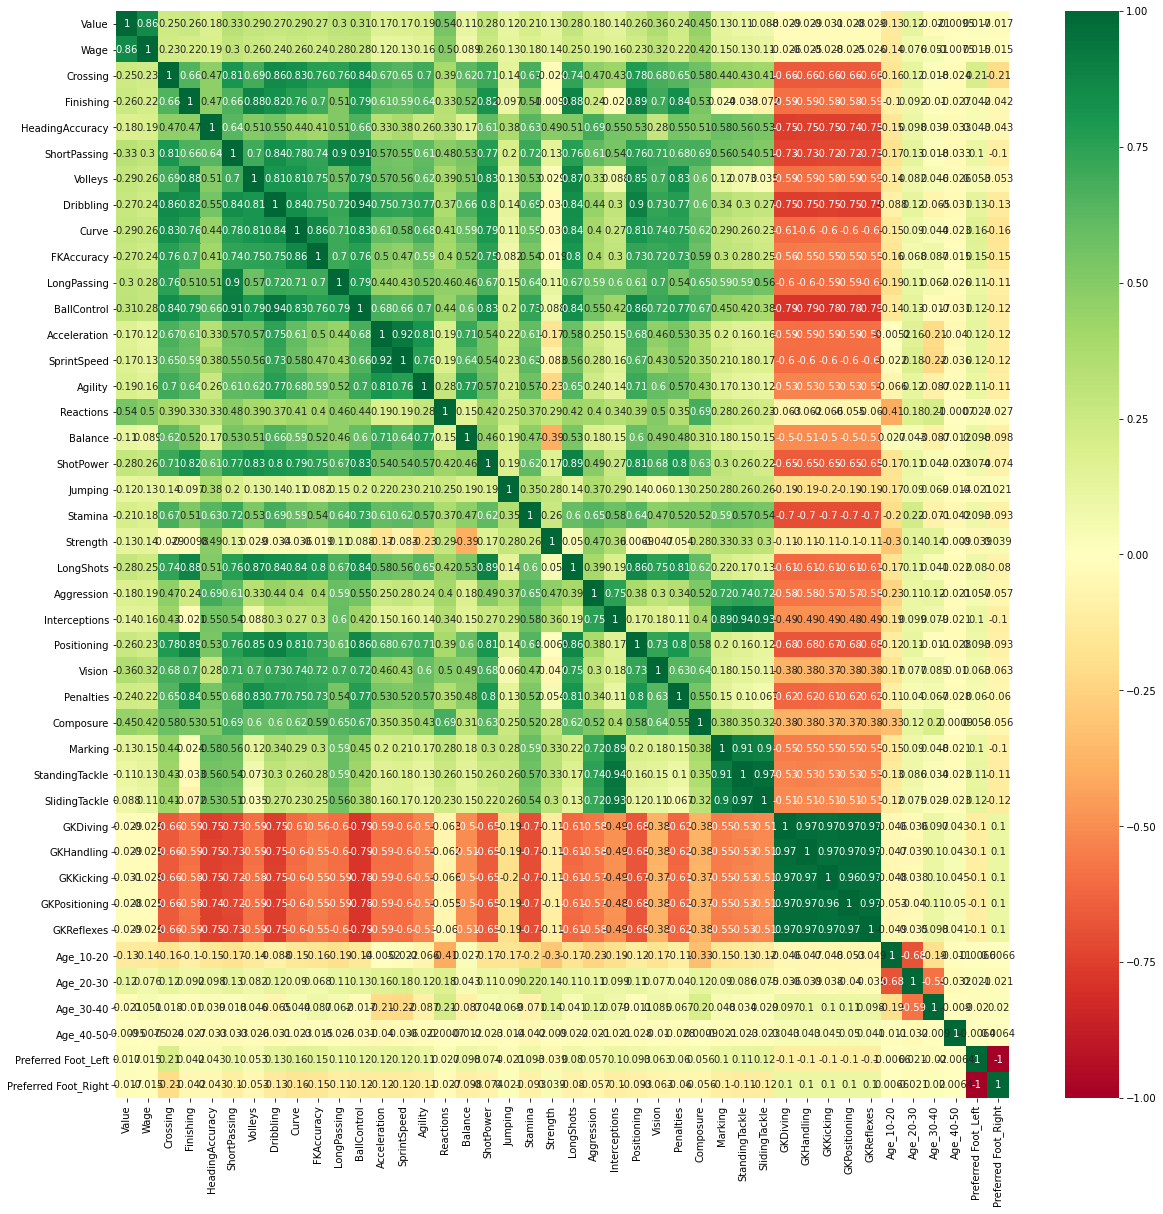

In [99]:
# We use the corr function of Pandas to find the correlation between independent variables. The default is Pearson Correlation method.

correlation= X.corr()


# to select the columns to drop we take each column at a time and to avoid checking for correlation with same column we use 
# another for loop and see if the correlation coefficient is above 0.85 (very high correlation) and before adding to to the list
# of variables to be removed we compare it with the dependent variable and the variable with low correlation coefficient with 
# respect to dependent variable is added it to a set (to avoid duplicates).


a=set()
for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i,j]>0.85):
            cola=correlation.columns[i]
            colb=correlation.columns[j]
            if abs(data.corr().loc['Overall',cola]) > abs(data.corr().loc['Overall',colb]):
                a.add(colb)
            else:
                a.add(cola)           
a

# Plotting the correlation heatmap

plt.figure(figsize=(20,20))

g= sns.heatmap(correlation,annot=True,cmap='RdYlGn')


In [102]:
# We drop those above variables from the independent variables.


X1= X.drop(a,axis=1)

X1.columns

# We split the newly transformed independent varaibles into train and test datas and fit a XGBoost regressor model on it

X_train1,X_test1,y_train1,y_test1= train_test_split(X1,y,test_size=0.3,random_state=42)

X_train1.shape,X_test1.shape

xgb_filter= XGBRegressor()

xgb_filter.fit(X_train1,y_train1)

pred_filter=xgb_filter.predict(X_test1)

mean_squared_error(y_test1,pred_filter)

r2_score(y_test1,pred_filter)


Index(['Value', 'Crossing', 'HeadingAccuracy', 'ShortPassing', 'Curve',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'Aggression', 'Interceptions',
       'Vision', 'Penalties', 'Composure', 'GKKicking', 'Age_10-20',
       'Age_20-30', 'Age_30-40', 'Age_40-50', 'Preferred Foot_Left',
       'Preferred Foot_Right'],
      dtype='object')

((12710, 25), (5448, 25))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.3145004649078002

1.0931904791791012

0.9771182616539553

> * We can see that the model has not given us any improvements when we removed the correlated variables from the data. There is a slight decrease in the model performance, I am not doing hypertuning on this.   

#### Feature Importance

Feature importance is the technique of assigning scores to input features based on their importance in doing prediction. It gives a better understanding of the model, data and helps to reduce the number of input features. It helps us to get an insight into which variables should we keep (high scores) and which variables we need to delete (low scores). Some models have built in attributes for feature importance eg: tree based algorithms. One thing to keep in mind that feature importance for variables might vary depending on the models we use. Features important for one model may not be important for another.

We use the XGBoost Regressor to get the feature importances for our features and use selectfrommodel module from Sklearn feature.selection for selecting the features based on the feature importances 

In [122]:
# Fitting the model and getting the feature importance scores for the variables

feature_imp= XGBRegressor()

feature_imp.fit(X_train,y_train)

# feature importance scores

importance= feature_imp.feature_importances_

# feature scores and variable names

features= zip(X_train.columns,importance)

#sorting the features

for i in sorted(features,key=lambda x:x[1],reverse=True):
    print(i)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

('Value', 0.49801743)
('Reactions', 0.12763725)
('Age_10-20', 0.10749777)
('Age_30-40', 0.08662346)
('Wage', 0.021568993)
('Age_20-30', 0.021126382)
('Composure', 0.01698978)
('GKPositioning', 0.012861608)
('Interceptions', 0.010876978)
('GKDiving', 0.01057298)
('StandingTackle', 0.009057162)
('SlidingTackle', 0.0077015013)
('Marking', 0.006572613)
('BallControl', 0.0065304353)
('Age_40-50', 0.0061903605)
('GKReflexes', 0.005229243)
('Crossing', 0.0039433558)
('GKHandling', 0.003590821)
('HeadingAccuracy', 0.0031248222)
('Aggression', 0.0028727083)
('Strength', 0.0027134367)
('Positioning', 0.0023461634)
('Stamina', 0.002229906)
('Jumping', 0.0017862786)
('Penalties', 0.0017149863)
('Dribbling', 0.0016523692)
('Preferred Foot_Left', 0.0015633987)
('GKKicking', 0.0015023525)
('Vision', 0.0013891543)
('LongShots', 0.0013682513)
('LongPassing', 0.0012929888)
('ShortPassing', 0.0012728309)
('Acceleration', 0.0012393406)
('Curve', 0.0012260649)
('Finishing', 0.0012198397)
('SprintSpeed', 0.

In [123]:
# To select the best features based on the scores we use SelectFromModel
# But since we do not know what threshold is the best for selecting models
# We pass each feature importance score as a threshold and
# transform our train and test sets using our selected variables and 
# look for model performance for selecting the threshold. 
# Also we have used prefit since we have fitted the model in the above step.

for i in sort(feature_imp.feature_importances_):
    sel= SelectFromModel(feature_imp,threshold=i,prefit=True)
    sel_x_train= sel.transform(X_train)
    sel_x_test= sel.transform(X_test)
    
    sel_model= XGBRegressor()
    sel_model.fit(sel_x_train,y_train)
    pred_y=sel_model.predict(sel_x_test)
    mean_sq_sel=mean_squared_error(y_test,pred_y)
    print("Thres= %.3f, n=%d, Sq_error: %.2f" % (i,sel_x_train.shape[1],mean_sq_sel))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.000, n=42, Sq_error: 0.72


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=41, Sq_error: 0.72


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=40, Sq_error: 0.70


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=39, Sq_error: 0.71


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=38, Sq_error: 0.70


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=37, Sq_error: 0.72


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=36, Sq_error: 0.70


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=35, Sq_error: 0.70


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=34, Sq_error: 0.71


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=33, Sq_error: 0.71


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=32, Sq_error: 0.73


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=31, Sq_error: 0.72


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=30, Sq_error: 0.73


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.001, n=29, Sq_error: 0.73


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.002, n=28, Sq_error: 0.75


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.002, n=27, Sq_error: 0.74


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.002, n=26, Sq_error: 0.75


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.002, n=25, Sq_error: 0.75


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.002, n=24, Sq_error: 0.75


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.002, n=23, Sq_error: 0.75


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.002, n=22, Sq_error: 0.77


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.003, n=21, Sq_error: 0.80


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.003, n=20, Sq_error: 0.81


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.003, n=19, Sq_error: 0.82


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.004, n=18, Sq_error: 0.89


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.004, n=17, Sq_error: 0.90


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.005, n=16, Sq_error: 0.94


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.006, n=15, Sq_error: 0.95


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.007, n=14, Sq_error: 0.96


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.007, n=13, Sq_error: 1.05


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.008, n=12, Sq_error: 1.11


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.009, n=11, Sq_error: 1.05


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.011, n=10, Sq_error: 1.17


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.011, n=9, Sq_error: 1.22


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.013, n=8, Sq_error: 1.44


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.017, n=7, Sq_error: 1.73


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.021, n=6, Sq_error: 1.68


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.022, n=5, Sq_error: 1.68


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.087, n=4, Sq_error: 1.84


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.107, n=3, Sq_error: 2.93


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.128, n=2, Sq_error: 3.68


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Thres= 0.498, n=1, Sq_error: 5.70


> * Since we were looping through the threshold values selectfrommodel was basically like a wrapper method with backward selection.
> * It gave the best variables at squared error of 0.70 but since we want to lower our number of features with the least squared root value we choose threshold 0.002 with 0.74 squared error.

In [124]:
# We again select the variables based on the above best threshold varlue and we need only a maximum of 27 variables for the best performance.

model_features= SelectFromModel(feature_imp,threshold=0.002,prefit=True,max_features=27)

# to get the indexes of the features selected

feature_index= model_features.get_support()

# The names of the features selected

feature_names= X_train.columns[feature_index]

print(X_train.columns[feature_index])



Index(['Value', 'Wage', 'Crossing', 'HeadingAccuracy', 'BallControl',
       'Reactions', 'Stamina', 'Strength', 'Aggression', 'Interceptions',
       'Positioning', 'Composure', 'Marking', 'StandingTackle',
       'SlidingTackle', 'GKDiving', 'GKHandling', 'GKPositioning',
       'GKReflexes', 'Age_10-20', 'Age_20-30', 'Age_30-40', 'Age_40-50'],
      dtype='object')


In [125]:
# We can check what column were skipped from selecting

print(X_train.drop(X_train.columns[feature_index],axis=1).columns)


Index(['Finishing', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'Acceleration', 'SprintSpeed', 'Agility',
       'Balance', 'ShotPower', 'Jumping', 'LongShots', 'Vision', 'Penalties',
       'GKKicking', 'Preferred Foot_Left', 'Preferred Foot_Right'],
      dtype='object')


In [126]:
# Building a new model with the selected variables. 
# You can also use the transform method of SelectFromModel to get the Train and test sets with the selected variables.


X_train_new= X_train[X_train.columns[feature_index]]
X_test_new=X_test[X_train.columns[feature_index]]

xgb_new= XGBRegressor()
xgb_new.fit(X_train_new,y_train)

y_pred_new=xgb_new.predict(X_test_new)

print(mean_squared_error(y_test,y_pred_new))
print(r2_score(y_test,y_pred_new))



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.746913988072444
0.9843662282396494


> * There is not much of a improvement from our original model.

#### Wrapper Method

Wrapper Method is another feature selection technique and is based on the alogrithm we fit the data. Wrapper methods are highly computationally expensive and time consuming as it uses a greedy search technique where it evaluates different combinations of features against the alogirthm evaluation metric and could possible lead to overfitting. Commonly used wrapper methods are forward selection, backward elimination and stepwise selection. We are going to do a forward selection based on a XGBoost Regressor Algorithm using SequentialFeatureSelector mlxtend library.

Forward selection starts with an empty set and adds one feature at a time and looks for the model performance, if the model performs bad with the addition of new feature it is removed. You can either explicitly give the number of features you want to select or you can check what is the optimal number of features. The scoring metric we use for feature selection is neg mean squared error and we do cross validation.

In [129]:
# Sequential Forward Feature Selector

sfs= SequentialFeatureSelector(XGBRegressor(),
                               k_features=20,
                               forward=True,
                               verbose=2,
                               scoring='neg_mean_squared_error',
                               cv=5)

sfs.fit(X_train,y_train)




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   57.9s finished

[2020-10-07 23:23:51] Features: 1/20 -- score: -5.527170238866277[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  1.0min finished

[2020-10-07 23:24:53] Features: 2/20 -- score: -2.8105775569670013[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.1min finished

[2020-10-07 23:25:57] Features: 3/20 -- score: -2.1578330604968534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

SequentialFeatureSelector(estimator=XGBRegressor(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 gamma=None, gpu_id=None,
                                                 importance_type='gain',
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=1

{1: {'feature_idx': (0,),
  'cv_scores': array([-5.85338258, -5.23987791, -5.7865306 , -5.62675938, -5.12930072]),
  'avg_score': -5.527170238866277,
  'feature_names': ('Value',),
  'ci_bound': 0.37447533354432616,
  'std_dev': 0.291354531655356,
  'std_err': 0.145677265827678},
 2: {'feature_idx': (0, 38),
  'cv_scores': array([-3.01793649, -2.67668154, -2.97238436, -2.74198453, -2.64390085]),
  'avg_score': -2.8105775569670013,
  'feature_names': ('Value', 'Age_30-40'),
  'ci_bound': 0.19877882324644455,
  'std_dev': 0.15465667765568683,
  'std_err': 0.0773283388278434},
 3: {'feature_idx': (0, 36, 38),
  'cv_scores': array([-2.26627069, -1.97422192, -2.41963547, -2.12511655, -2.00392067]),
  'avg_score': -2.1578330604968534,
  'feature_names': ('Value', 'Age_10-20', 'Age_30-40'),
  'ci_bound': 0.21412473240498373,
  'std_dev': 0.1665963163320019,
  'std_err': 0.08329815816600093},
 4: {'feature_idx': (0, 15, 36, 38),
  'cv_scores': array([-2.01582477, -1.84733375, -1.96553988, -1.7

In [130]:
# A detailed look at each iteration

sfs.get_metric_dict()

{1: {'feature_idx': (0,),
  'cv_scores': array([-5.85338258, -5.23987791, -5.7865306 , -5.62675938, -5.12930072]),
  'avg_score': -5.527170238866277,
  'feature_names': ('Value',),
  'ci_bound': 0.37447533354432616,
  'std_dev': 0.291354531655356,
  'std_err': 0.145677265827678},
 2: {'feature_idx': (0, 38),
  'cv_scores': array([-3.01793649, -2.67668154, -2.97238436, -2.74198453, -2.64390085]),
  'avg_score': -2.8105775569670013,
  'feature_names': ('Value', 'Age_30-40'),
  'ci_bound': 0.19877882324644455,
  'std_dev': 0.15465667765568683,
  'std_err': 0.0773283388278434},
 3: {'feature_idx': (0, 36, 38),
  'cv_scores': array([-2.26627069, -1.97422192, -2.41963547, -2.12511655, -2.00392067]),
  'avg_score': -2.1578330604968534,
  'feature_names': ('Value', 'Age_10-20', 'Age_30-40'),
  'ci_bound': 0.21412473240498373,
  'std_dev': 0.1665963163320019,
  'std_err': 0.08329815816600093},
 4: {'feature_idx': (0, 15, 36, 38),
  'cv_scores': array([-2.01582477, -1.84733375, -1.96553988, -1.7

In [132]:
#the selected features

selected_features = X_train.columns[list(sfs.k_feature_idx_)]

selected_features

Index(['Value', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'BallControl', 'SprintSpeed', 'Reactions', 'ShotPower', 'Aggression',
       'Interceptions', 'Positioning', 'Marking', 'StandingTackle', 'GKDiving',
       'GKHandling', 'GKPositioning', 'Age_10-20', 'Age_20-30', 'Age_30-40'],
      dtype='object')

In [134]:
# Transforming the train and test data based on the selected features

X_train_sfs= sfs.transform(X_train)
X_test_sfs= sfs.transform(X_test)

# fitting a XGBRegressor 

sfs_xgb=XGBRegressor()
sfs_xgb.fit(X_train_sfs,y_train)

sfs_y_pred=sfs_xgb.predict(X_test_sfs)

print(mean_squared_error(sfs_y_pred,y_test))



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.7673636090418905


> * We cannot see any improvements nor can say the model performed badly. However you can see and try for the optimal number of features with hit and trial method and plot the scores to see the optimal features that can give the best results, but since it will take very long time to finish i decided not to try it.


Also keep in mind that there are other methods of feature selection available. Embedded methods, Dimensionality Reduction (PCA) and many more are available.  